In [1]:
import math

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPYNBrenderer import render_google_doc
from tensorflow import keras
import tensorflow as tf
cf.go_offline(connected=True)

2022-10-23 02:30:17.232579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


$$ \ m = \beta m + \eta \frac{\partial c}{\partial w _{(w=wcurrent)}}

$$ \ w_{new} = w_{current} - m_{current}

In [2]:
def MSE_loss(target_y, predicted_y):
  error = target_y - predicted_y
  squared_error = tf.square(error)
  mse = tf.reduce_mean(squared_error)
  return mse

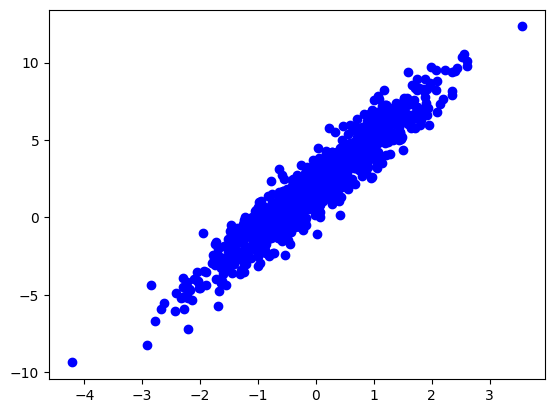

In [3]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000


x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, c='b')

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # initial weights
    self.w = tf.Variable(5.0) # TRUE_W = 3.0
    self.b = tf.Variable(0.0) # TRUE_B = 2.0
    self.w_m = tf.Variable(0.0)
    self.b_m =  tf.Variable(0.0)

  def __call__(self, x):
    return self.w*x + self.b

In [5]:
model = MyModel()

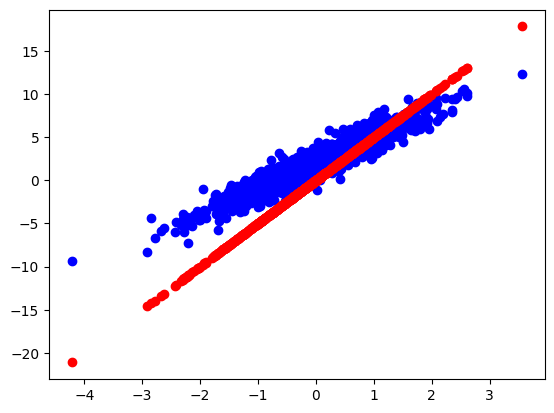

In [6]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()


In [7]:
def momentum_optimizer_train(model, x, y, learning_rate , momentum):

  with tf.GradientTape() as tape:
    y_hat = model(x)
    current_loss = MSE_loss(y, y_hat)

  dc_dw, dc_db = tape.gradient(current_loss, [model.w, model.b])
  mw_new = momentum * model.w_m + learning_rate * dc_dw
  mb_new = momentum * model.b_m + learning_rate * dc_db

  model.w.assign_sub(mw_new) # w = w - n * grad => w -= n*grad_w
  model.b.assign_sub(mb_new) # b = b - n * grad => b -= n*grad_b
  model.b_m.assign(mb_new)
  model.w_m.assign(mw_new)
  return current_loss

In [8]:
model = MyModel()

Ws, bs , mw , mb  = list(), list() , list() , list()
LOSS = list()
epochs = 20

learning_rate = 0.9 # LARGE LEARNING RATE

w = model.w.numpy()
b = model.b.numpy()

init_loss = MSE_loss(y, model(x)).numpy()

print(f"initial W: {w}, initial_bias: {b}, initial loss: {init_loss}")

initial W: 5.0, initial_bias: 0.0, initial loss: 8.671427726745605


In [9]:
for epoch in range(epochs):
  momentum_optimizer_train(model, x, y, learning_rate , momentum = 0.9)

  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  mw.append(model.w_m.numpy())
  mb.append(model.b_m.numpy())
  current_loss = MSE_loss(y, model(x))
  LOSS.append(current_loss.numpy())

  print(f"For epoch: {epoch}, W: {Ws[-1]}, initial_bias: {bs[-1]}, current loss: {current_loss}")

For epoch: 0, W: 1.5805444717407227, initial_bias: 3.544200897216797, current loss: 5.232354640960693
For epoch: 1, W: 1.0163495540618896, initial_bias: 4.062142372131348, current loss: 8.91385269165039
For epoch: 2, W: 4.003966331481934, initial_bias: 0.9511361122131348, current loss: 2.97942852973938
For epoch: 3, W: 5.005373477935791, initial_bias: 0.03101789951324463, current loss: 8.570693969726562
For epoch: 4, W: 2.476111650466919, initial_bias: 2.691023349761963, current loss: 1.6810599565505981
For epoch: 5, W: 1.155689001083374, initial_bias: 3.9060819149017334, current loss: 7.794857501983643
For epoch: 6, W: 3.2215025424957275, initial_bias: 1.6967265605926514, current loss: 1.0869828462600708
For epoch: 7, W: 4.753993511199951, initial_bias: 0.2834494113922119, current loss: 6.757166862487793
For epoch: 8, W: 3.1392407417297363, initial_bias: 2.0572566986083984, current loss: 0.9618372321128845
For epoch: 9, W: 1.4887832403182983, initial_bias: 3.5838050842285156, current 

In [10]:
data = pd.DataFrame({"W": Ws, "b": bs, "mw": mw, "mb": mb})

In [11]:
data["w_true"] = TRUE_W
data["b_true"] = TRUE_B
data['epoch'] = range(epochs)
data['loss'] = LOSS

In [12]:
data.iplot(kind="scatter" , x="epoch", y=["W" , "b" , "w_true" , "b_true"], mode="lines+markers", title="W vs epoch")

In [13]:
data.iplot(kind="scatter" , x="epoch", y=["loss", "W" , "b" ], mode="lines+markers", title="W vs epoch")

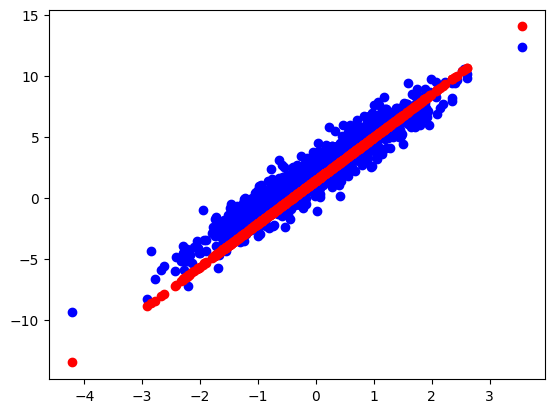

In [14]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full
X_test = X_test 
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [16]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard("tensor_board_logs")
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3 , momentum=0.9), metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
1719/1719 [==============================] - 26s 14ms/step - loss: 0.5563 - accuracy: 0.8057 - val_loss: 0.4413 - val_accuracy: 0.8614
Epoch 2/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4186 - accuracy: 0.8508 - val_loss: 0.4091 - val_accuracy: 0.8688
Epoch 3/30
1719/1719 [==============================] - 25s 14ms/step - loss: 0.3820 - accuracy: 0.8624 - val_loss: 0.3849 - val_accuracy: 0.8752
Epoch 4/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3585 - accuracy: 0.8713 - val_loss: 0.3784 - val_accuracy: 0.8754
Epoch 5/30
1719/1719 [==============================] - 20s 11ms/step - loss: 0.3431 - accuracy: 0.8765 - val_loss: 0.3759 - val_accuracy: 0.8808
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3275 - accuracy: 0.8809 - val_loss: 0.4461 - val_accuracy: 0.8776
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3149 - accuracy: 0.8861 - val_loss: 0.3855 - val

#### Drawbacks 
$ \beta$  = one more parameter to tune , even though $ \beta$ = 0.9 works fine 
oscillation when it reaches the minimum as accumulation of the past momentum  
#### Advantage 
momentum helps to coverage faster 
oscillation can help to come out of local minimum if any 